# Coördinated Spiking Model (2-dimensional)

Install required packages

In [95]:
import numpy as np
import pylab as pl

In [169]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

## Single-neuron

Initialize parameters

In [171]:
def initialize_params_single(d, iterations, dt, weight_x1, weight_x2):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros(iterations)

    # input estimate
    x_est = np.ones((d, iterations)) * 0.5

    # spike train
    o = np.zeros(iterations)

    # decoding weights
    D = np.zeros(d)
    D[0] = weight_x1
    D[1] = weight_x2

    # threshold
    T = np.dot(D, D) / 2
    
    return (t, voltage, x_est, o, D, T)

In [209]:
def TVS_single(cycles):

    # input signal
    x1 = np.sin(np.linspace(-cycles * np.pi, cycles * np.pi, iterations))
    dx1dt = np.diff(x1)/dt
    c1 = x1[:-1] + dx1dt

    x2 = x = np.sin(np.linspace(-cycles * np.pi, cycles * np.pi, iterations))
    dx2dt = np.diff(x2)/dt
    c2 = x2[:-1] + dx2dt

    c = np.array([c1, c2])
    x = np.array([x1, x2])
    
    return(c, x)

In [165]:
def run_single():
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[:, t - 1] + o[t - 1] * D.T
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltage
        dVdt = -voltage[t - 1] + np.dot(D, x[:, t - 1] +  c[:, t - 1]) - np.dot(D, D) * o[t - 1]
        voltage[t] = voltage[t - 1] + dt * dVdt

            # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

In [226]:
def plot_single():
    
    plot = 4
    pl.subplots(plot, 1, figsize=(8, 9))
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    # pl.subplots_adjust(hspace=0.7)

    pl.subplot(plot, 1, 1)
    pl.plot(x_est[0,:], label=r'$\hat{x}_{1}$', color='gray')
    pl.plot(x[0,:], label='$x_{1}$', color='k')
    pl.yticks([])
    pl.xticks([])
    
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    pl.subplot(plot, 1, 2)
    pl.plot(x_est[1,:], label=r'$\hat{x}_{2}$', color='gray')
    pl.plot(x[1,:], label='$x_{2}$', color='k')
    pl.yticks([])
    pl.xticks([])
    
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    pl.subplot(plot, 1, 3)
    pl.title('Spike train')
    spikes = zero_to_nan(o)
    pl.scatter(range(0, iterations), spikes, s=0.5)
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    
    pl.subplot(plot, 1, 4)
    pl.plot(voltage, label='voltage')
    pl.xlabel('time')
    pl.ylabel('Voltage')
    pl.yticks([])
    pl.xticks([])


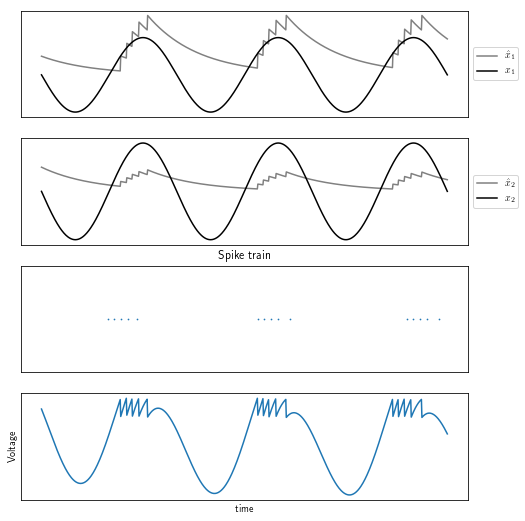

In [227]:
d = 2
iterations = 800
dt = 0.01
weight_x1 = 0.4
weight_x2 = 0.1
cycles = 3

t, voltage, x_est, o, D, T = initialize_params_single(d, iterations, dt, weight_x1, weight_x2)
c, x = TVS_single(cycles)
run_single()
plot_single()

## $\textit{N}$-neurons

Initialize parameters

In [228]:
def initialize_params_N(N, d, iterations, dt, weight_x1, weight_x2):
    
    # timesteps
    t = np.arange(0, iterations) * dt

    # voltage
    voltage = np.zeros((N, iterations))

    # input estimate
    x_est = np.ones((d, iterations)) * 0.5

    # spike train
    o = np.zeros((N, iterations))

    # decoding weights
    D = np.zeros(d)
    D[0] = weight_x1
    D[1] = weight_x2

    # threshold
    T = np.dot(D, D) / 2
    
    return (t, voltage, x_est, o, D, T)

In [166]:
def TVS_single(cycles):

    # input signal
    x1 = np.sin(np.linspace(-cycles * np.pi, cycles * np.pi, iterations))
    dx1dt = np.diff(x1)/dt
    c1 = x1[:-1] + dx1dt

    x2 = x = np.sin(np.linspace(-cycles * np.pi, cycles * np.pi, iterations))
    dx2dt = np.diff(x2)/dt
    c2 = x2[:-1] + dx2dt

    c = np.array([c1, c2])
    x = np.array([x1, x2])
    
    return(c, x)

In [165]:
def run_single():
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[:, t - 1] + o[t - 1] * D.T
        x_est[:, t] = x_est[:, t - 1] + dt * dxestdt

        # update voltage
        dVdt = -voltage[t - 1] + np.dot(D, x[:, t - 1] +  c[:, t - 1]) - np.dot(D, D) * o[t - 1]
        voltage[t] = voltage[t - 1] + dt * dVdt

            # spike when voltage exceeds threshold
        if voltage[t] > T:
            o[t] = 1/dt

In [198]:
def plot_single():
    
    plot = 4
    pl.subplots(plot, 1, figsize=(8, 9))
    
    # enable LaTeX
    pl.rc('text', usetex=True)
    # pl.subplots_adjust(hspace=0.7)

    pl.subplot(plot, 1, 1)
    pl.plot(x_est[0,:], label=r'$\hat{x}_{1}$', color='gray')
    pl.plot(x[0,:], label='$x_{1}$', color='k')
    pl.yticks([])
    pl.xticks([])
    
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    pl.subplot(plot, 1, 2)
    pl.plot(x_est[1,:], label=r'$\hat{x}_{2}$', color='gray')
    pl.plot(x[1,:], label='$x_{2}$', color='k')
    pl.yticks([])
    pl.xticks([])
    
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    pl.subplot(plot, 1, 3)
    pl.title('Spike train')
    spikes = zero_to_nan(o)
    pl.scatter(range(0, iterations), spikes, s=0.5)
    pl.xlim(0, iterations)
    pl.yticks([])
    pl.xticks([])
    
    pl.subplot(plot, 1, 4)
    pl.plot(voltage, label='voltage')
    pl.xlabel('time')
    pl.ylabel('Voltage')
    pl.yticks([])
    pl.xticks([])

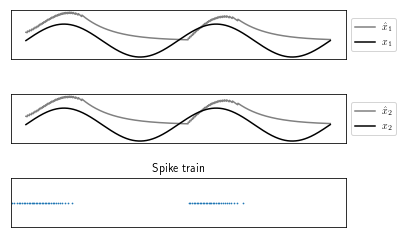

In [199]:
N = 2
d = 2
iterations = 1000
dt = 0.01
weight_x1 = 0.1
weight_x2 = 0.1
cycles = 3

t, voltage, x_est, o, D, T = initialize_params_N(N, d, iterations, dt, weight_x1, weight_x2)
c, x = TVS_N(cycles)
run_N()
plot_N()